#U23AI009 AMEESH DL LAB 02

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import copy

BATCH_SIZE = 64
TEST_BATCH_SIZE = 1000
EPOCHS_PHASE_1 = 10
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

print("Data Loaders ready.")

Using device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.91MB/s]

Data Loaders ready.


##Finding best Architecture
CNN-1 vs MLP-1 vs MLP-2

Optimizer = Adam. Epochs = 10. Activation = ReLU.

In [2]:
class CNN_1(nn.Module):
    def __init__(self):
        super(CNN_1, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class MLP_1(nn.Module):

    def __init__(self):
        super(MLP_1, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x

class MLP_2(nn.Module):

    def __init__(self):
        super(MLP_2, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

def train_and_evaluate(model_class, name, epochs=10, optimizer_type='Adam'):
    model = model_class().to(DEVICE)

    if optimizer_type == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    else:
        optimizer = optim.SGD(model.parameters(), lr=0.01)

    criterion = nn.CrossEntropyLoss()

    history = {'train_loss': [], 'val_acc': []}

    print(f"--- Training {name} ---")
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        model.eval()
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(DEVICE), target.to(DEVICE)
                output = model(data)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        val_acc = 100. * correct / len(test_loader.dataset)

        history['train_loss'].append(avg_train_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.2f}%")

    return history

--- Training CNN-1 ---
Epoch 1/10 | Loss: 0.1250 | Val Acc: 98.42%
Epoch 2/10 | Loss: 0.0412 | Val Acc: 98.79%
Epoch 3/10 | Loss: 0.0264 | Val Acc: 99.02%
Epoch 4/10 | Loss: 0.0200 | Val Acc: 98.64%
Epoch 5/10 | Loss: 0.0162 | Val Acc: 98.96%
Epoch 6/10 | Loss: 0.0123 | Val Acc: 98.93%
Epoch 7/10 | Loss: 0.0103 | Val Acc: 98.77%
Epoch 8/10 | Loss: 0.0100 | Val Acc: 98.84%
Epoch 9/10 | Loss: 0.0084 | Val Acc: 99.07%
Epoch 10/10 | Loss: 0.0075 | Val Acc: 99.03%
--- Training MLP-1 ---
Epoch 1/10 | Loss: 0.1983 | Val Acc: 97.27%
Epoch 2/10 | Loss: 0.0877 | Val Acc: 98.08%
Epoch 3/10 | Loss: 0.0637 | Val Acc: 97.90%
Epoch 4/10 | Loss: 0.0492 | Val Acc: 97.80%
Epoch 5/10 | Loss: 0.0381 | Val Acc: 97.82%
Epoch 6/10 | Loss: 0.0328 | Val Acc: 98.26%
Epoch 7/10 | Loss: 0.0293 | Val Acc: 98.26%
Epoch 8/10 | Loss: 0.0248 | Val Acc: 98.03%
Epoch 9/10 | Loss: 0.0213 | Val Acc: 98.24%
Epoch 10/10 | Loss: 0.0210 | Val Acc: 98.41%
--- Training MLP-2 ---
Epoch 1/10 | Loss: 0.2034 | Val Acc: 97.15%
Epoch

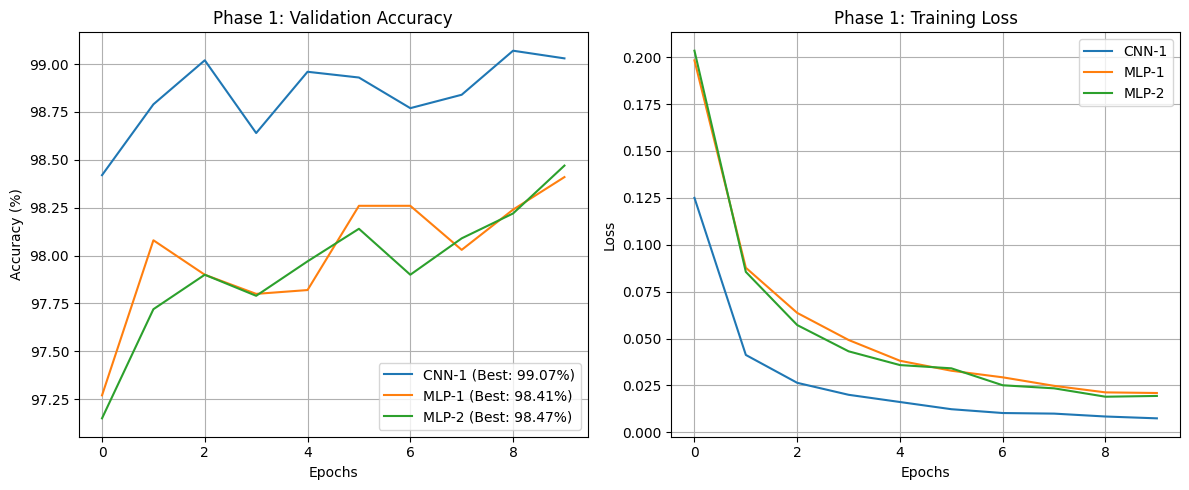


Phase 1 Winner: CNN-1


In [2]:
phase1_results = {}
models_to_test = [
    ('CNN-1', CNN_1),
    ('MLP-1', MLP_1),
    ('MLP-2', MLP_2)
]

for name, model_cls in models_to_test:
    phase1_results[name] = train_and_evaluate(model_cls, name, epochs=EPOCHS_PHASE_1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for name, hist in phase1_results.items():
    plt.plot(hist['val_acc'], label=f"{name} (Best: {max(hist['val_acc']):.2f}%)")
plt.title("Phase 1: Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for name, hist in phase1_results.items():
    plt.plot(hist['train_loss'], label=name)
plt.title("Phase 1: Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

best_model_name = max(phase1_results, key=lambda k: max(phase1_results[k]['val_acc']))
print(f"\nPhase 1 Winner: {best_model_name}")

### Architecture Selection

Based on the experiments, the CNN architecture significantly outperformed the MLP configurations.

| Model | Validation Accuracy (%) |
| :--- | :--- |
| **CNN-1** | **99.07** |
| MLP-1 | 98.41 |
| MLP-2 | 98.47 |

**Conclusion:** We will proceed with **CNN-1** as our base architecture for the remaining assignment.

##Evaluating Activation Functions

Sigmoid vs Tanh vs ReLU

Architecture: CNN-1, Optimizer: Adam, Epochs: 10

--- Activation Comparison on CNN-1 ---
--- Training CNN + ReLU ---
Epoch 1/10 | Loss: 0.1247 | Val Acc: 98.31%
Epoch 2/10 | Loss: 0.0416 | Val Acc: 98.78%
Epoch 3/10 | Loss: 0.0263 | Val Acc: 98.95%
Epoch 4/10 | Loss: 0.0197 | Val Acc: 99.05%
Epoch 5/10 | Loss: 0.0164 | Val Acc: 98.90%
Epoch 6/10 | Loss: 0.0124 | Val Acc: 99.00%
Epoch 7/10 | Loss: 0.0107 | Val Acc: 99.01%
Epoch 8/10 | Loss: 0.0094 | Val Acc: 99.03%
Epoch 9/10 | Loss: 0.0080 | Val Acc: 98.99%
Epoch 10/10 | Loss: 0.0082 | Val Acc: 99.08%
--- Training CNN + Sigmoid ---
Epoch 1/10 | Loss: 0.7262 | Val Acc: 95.37%
Epoch 2/10 | Loss: 0.1288 | Val Acc: 98.02%
Epoch 3/10 | Loss: 0.0708 | Val Acc: 98.28%
Epoch 4/10 | Loss: 0.0487 | Val Acc: 98.51%
Epoch 5/10 | Loss: 0.0378 | Val Acc: 98.57%
Epoch 6/10 | Loss: 0.0287 | Val Acc: 98.84%
Epoch 7/10 | Loss: 0.0225 | Val Acc: 98.77%
Epoch 8/10 | Loss: 0.0184 | Val Acc: 98.88%
Epoch 9/10 | Loss: 0.0153 | Val Acc: 98.96%
Epoch 10/10 | Loss: 0.0117 | Val Acc: 99.02%
--- Training CNN + T

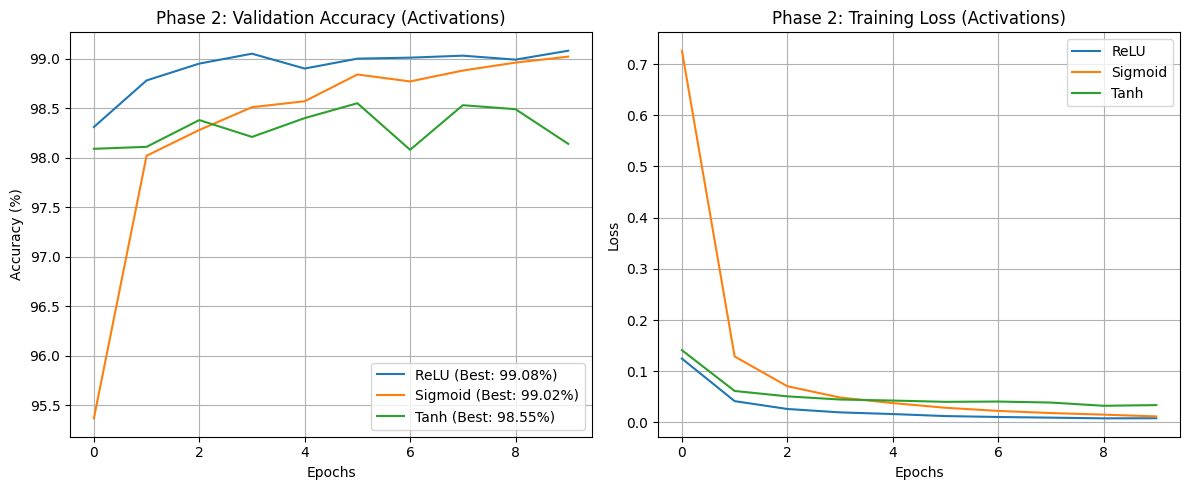


Phase 2 Winner: ReLU


In [3]:
class CNN_Var_Activation(nn.Module):

    def __init__(self, activation_module):
        super(CNN_Var_Activation, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        self.activation = activation_module

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

activation_candidates = [
    ('ReLU', nn.ReLU()),
    ('Sigmoid', nn.Sigmoid()),
    ('Tanh', nn.Tanh())
]

phase2_results = {}

print("--- Activation Comparison on CNN-1 ---")

for act_name, act_fn in activation_candidates:
    model_factory = lambda: CNN_Var_Activation(act_fn)
    history = train_and_evaluate(model_factory, f"CNN + {act_name}", epochs=10)
    phase2_results[act_name] = history

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for name, hist in phase2_results.items():
    plt.plot(hist['val_acc'], label=f"{name} (Best: {max(hist['val_acc']):.2f}%)")
plt.title("Phase 2: Validation Accuracy (Activations)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for name, hist in phase2_results.items():
    plt.plot(hist['train_loss'], label=name)
plt.title("Phase 2: Training Loss (Activations)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

best_activation = max(phase2_results, key=lambda k: max(phase2_results[k]['val_acc']))
print(f"\nPhase 2 Winner: {best_activation}")

### Activation Function Selection

The ReLU activation function achieved the highest validation accuracy, confirming its suitability for this CNN architecture.

| Activation Function | Validation Accuracy (%) |
| :--- | :--- |
| **ReLU** | **99.08** |
| Sigmoid | 99.02 |
| Tanh | 98.55 |

**Conclusion:** We will proceed with **ReLU** as the fixed activation function for the optimizer comparison.

##Evaluating Optimizers

SGD vs SGD w/ Momentum vs Adam

Architecture: CNN-1, Epochs: 10, Activation Function: ReLU

--- Optimizer Comparison on CNN (ReLU) ---
Training with SGD...
  Ep 1: Loss=0.4100 | Val Acc=93.43%
  Ep 2: Loss=0.1764 | Val Acc=96.31%
  Ep 3: Loss=0.1261 | Val Acc=96.38%
  Ep 4: Loss=0.0977 | Val Acc=97.60%
  Ep 5: Loss=0.0795 | Val Acc=97.82%
  Ep 6: Loss=0.0665 | Val Acc=98.01%
  Ep 7: Loss=0.0580 | Val Acc=98.20%
  Ep 8: Loss=0.0506 | Val Acc=98.32%
  Ep 9: Loss=0.0451 | Val Acc=98.44%
  Ep 10: Loss=0.0402 | Val Acc=98.53%
Training with SGD + Momentum...
  Ep 1: Loss=0.1860 | Val Acc=98.50%
  Ep 2: Loss=0.0509 | Val Acc=98.79%
  Ep 3: Loss=0.0340 | Val Acc=98.87%
  Ep 4: Loss=0.0250 | Val Acc=98.97%
  Ep 5: Loss=0.0186 | Val Acc=98.93%
  Ep 6: Loss=0.0149 | Val Acc=99.08%
  Ep 7: Loss=0.0112 | Val Acc=98.98%
  Ep 8: Loss=0.0090 | Val Acc=99.09%
  Ep 9: Loss=0.0082 | Val Acc=99.18%
  Ep 10: Loss=0.0080 | Val Acc=99.18%
Training with Adam...
  Ep 1: Loss=0.1197 | Val Acc=97.95%
  Ep 2: Loss=0.0399 | Val Acc=98.81%
  Ep 3: Loss=0.0263 | Val Acc=98.83%
  Ep 4: Loss=0.0190 | Val Acc

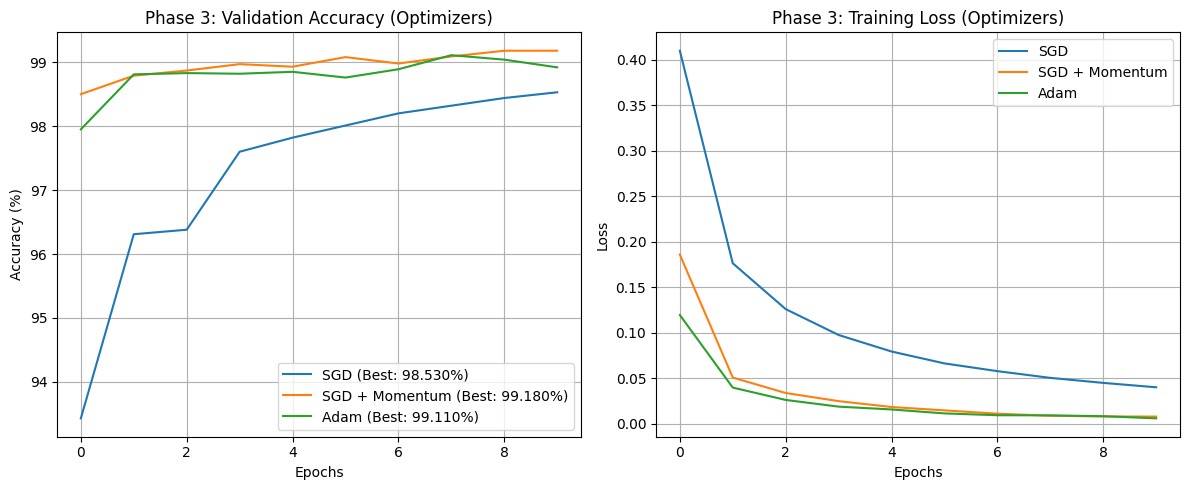


Phase 3 Winner: SGD + Momentum


In [5]:
try:
    model_factory = lambda: CNN_Var_Activation(nn.ReLU())
except NameError:
    model_factory = CNN_1

optimizer_configs = [
    {
        'name': 'SGD',
        'opt_func': lambda p: optim.SGD(p, lr=0.01)
    },
    {
        'name': 'SGD + Momentum',
        'opt_func': lambda p: optim.SGD(p, lr=0.01, momentum=0.9)
    },
    {
        'name': 'Adam',
        'opt_func': lambda p: optim.Adam(p, lr=0.001)
    }
]

phase3_results = {}

print("--- Optimizer Comparison on CNN (ReLU) ---")

for config in optimizer_configs:
    opt_name = config['name']

    model = model_factory().to(DEVICE)

    optimizer = config['opt_func'](model.parameters())
    criterion = nn.CrossEntropyLoss()

    history = {'train_loss': [], 'val_acc': []}

    print(f"Training with {opt_name}...")

    for epoch in range(10):
        model.train()
        running_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        model.eval()
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(DEVICE), target.to(DEVICE)
                output = model(data)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        val_acc = 100. * correct / len(test_loader.dataset)
        history['train_loss'].append(avg_train_loss)
        history['val_acc'].append(val_acc)

        print(f"  Ep {epoch+1}: Loss={avg_train_loss:.4f} | Val Acc={val_acc:.2f}%")

    phase3_results[opt_name] = history

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for name, hist in phase3_results.items():
    plt.plot(hist['val_acc'], label=f"{name} (Best: {max(hist['val_acc']):.2f}%)")
plt.title("Phase 3: Validation Accuracy (Optimizers)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for name, hist in phase3_results.items():
    plt.plot(hist['train_loss'], label=name)
plt.title("Phase 3: Training Loss (Optimizers)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

best_optimizer = max(phase3_results, key=lambda k: max(phase3_results[k]['val_acc']))
print(f"\nPhase 3 Winner: {best_optimizer}")

### Optimizer Selection

SGD with Momentum proved to be the most effective optimizer, slightly edging out Adam and significantly outperforming standard SGD.

| Optimizer | Validation Accuracy (%) |
| :--- | :--- |
| SGD | 98.53 |
| **SGD + Momentum** | **99.18** |
| Adam | 99.11 |

**Conclusion:** We will proceed with **SGD + Momentum** as our fixed optimizer.

##Evaluating Batch Normalization & Dropout

Without BN & Dropout=0 vs Without BN & Dropout=0.1 vs With BN & Dropout=0.25

Architecture: CNN-1, Epochs: 10, Activation Function: ReLU, Optimizer: SGD w/ Momentum

--- Batch Normalization & Dropout ---
Training No BN, No Dropout...
  Ep 1: Loss=0.1955 | Val Acc=98.45%
  Ep 2: Loss=0.0467 | Val Acc=98.49%
  Ep 3: Loss=0.0299 | Val Acc=98.89%
  Ep 4: Loss=0.0205 | Val Acc=99.07%
  Ep 5: Loss=0.0151 | Val Acc=99.06%
  Ep 6: Loss=0.0098 | Val Acc=98.96%
  Ep 7: Loss=0.0067 | Val Acc=99.01%
  Ep 8: Loss=0.0048 | Val Acc=98.94%
  Ep 9: Loss=0.0032 | Val Acc=99.09%
  Ep 10: Loss=0.0019 | Val Acc=99.07%
Training No BN, Dropout=0.1...
  Ep 1: Loss=0.1809 | Val Acc=98.26%
  Ep 2: Loss=0.0468 | Val Acc=98.89%
  Ep 3: Loss=0.0304 | Val Acc=98.87%
  Ep 4: Loss=0.0217 | Val Acc=98.84%
  Ep 5: Loss=0.0162 | Val Acc=98.86%
  Ep 6: Loss=0.0114 | Val Acc=99.10%
  Ep 7: Loss=0.0083 | Val Acc=98.83%
  Ep 8: Loss=0.0080 | Val Acc=98.95%
  Ep 9: Loss=0.0034 | Val Acc=99.03%
  Ep 10: Loss=0.0035 | Val Acc=99.04%
Training With BN, Dropout=0.25...
  Ep 1: Loss=0.1204 | Val Acc=98.68%
  Ep 2: Loss=0.0433 | Val Acc=98.97%
  Ep 3: Loss=0.0322 | Val Acc=99.04%
  Ep 4: Loss=0

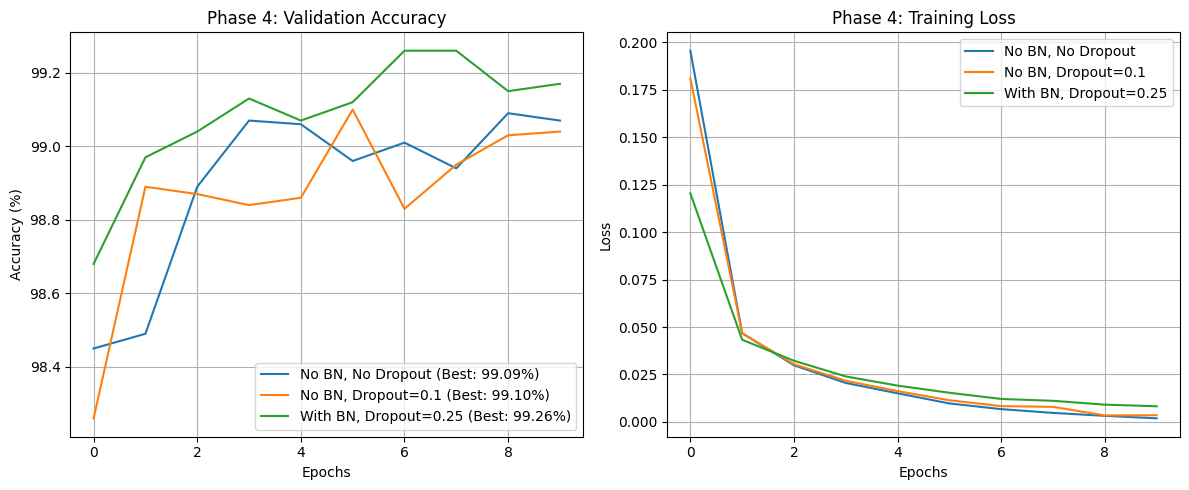


Phase 4 Winner: With BN, Dropout=0.25


In [6]:
class CNN_Configurable(nn.Module):
    def __init__(self, use_bn=False, dropout_rate=0.25):
        super(CNN_Configurable, self).__init__()
        self.use_bn = use_bn

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32) if use_bn else nn.Identity()

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64) if use_bn else nn.Identity()

        self.pool = nn.MaxPool2d(2, 2)

        self.dropout = nn.Dropout(dropout_rate)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(9216, 128)
        self.bn3 = nn.BatchNorm1d(128) if use_bn else nn.Identity()

        self.fc2 = nn.Linear(128, 10)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        if self.use_bn: x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        if self.use_bn: x = self.bn2(x)
        x = self.relu(x)

        x = self.pool(x)
        x = self.dropout(x)
        x = self.flatten(x)

        x = self.fc1(x)
        if self.use_bn: x = self.bn3(x)
        x = self.relu(x)

        x = self.fc2(x)
        return x

optimizer_factory = lambda p: optim.SGD(p, lr=0.01, momentum=0.9)

scenarios = [
    {
        'name': 'No BN, No Dropout',
        'use_bn': False,
        'dropout': 0.0
    },
    {
        'name': 'No BN, Dropout=0.1',
        'use_bn': False,
        'dropout': 0.1
    },
    {
        'name': 'With BN, Dropout=0.25',
        'use_bn': True,
        'dropout': 0.25
    }
]

phase4_results = {}

print("--- Batch Normalization & Dropout ---")

for scen in scenarios:
    name = scen['name']

    model_factory = lambda: CNN_Configurable(use_bn=scen['use_bn'], dropout_rate=scen['dropout'])

    model = model_factory().to(DEVICE)
    optimizer = optimizer_factory(model.parameters())
    criterion = nn.CrossEntropyLoss()

    history = {'train_loss': [], 'val_acc': []}

    print(f"Training {name}...")
    for epoch in range(10):
        model.train()
        running_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        model.eval()
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(DEVICE), target.to(DEVICE)
                output = model(data)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        val_acc = 100. * correct / len(test_loader.dataset)
        history['train_loss'].append(avg_train_loss)
        history['val_acc'].append(val_acc)

        print(f"  Ep {epoch+1}: Loss={avg_train_loss:.4f} | Val Acc={val_acc:.2f}%")

    phase4_results[name] = history

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for name, hist in phase4_results.items():
    plt.plot(hist['val_acc'], label=f"{name} (Best: {max(hist['val_acc']):.2f}%)")
plt.title("Phase 4: Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for name, hist in phase4_results.items():
    plt.plot(hist['train_loss'], label=name)
plt.title("Phase 4: Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

best_scenario = max(phase4_results, key=lambda k: max(phase4_results[k]['val_acc']))
print(f"\nPhase 4 Winner: {best_scenario}")

### Selecting Optimal Configuration

The configuration using both Batch Normalization and a Dropout rate of 0.25 yielded the highest accuracy, demonstrating the effectiveness of these regularization techniques in preventing overfitting.

| Scenario | Validation Accuracy (%) |
| :--- | :--- |
| Without BN, No Dropout | 99.09 |
| Without BN, Dropout=0.1 | 99.10 |
| **With BN, Dropout=0.25** | **99.26** |

**Conclusion:** We have identified our optimal model: **CNN + ReLU + SGD(Momentum) + Batch Norm + Dropout(0.25)**.

##Optimizing with Early Stopping

We have identified the Optimal model for our purposes. We will now attempt to train this model with early stopping instead of a fixed number of epochs in order to maximize its accuracy.

Architecture: CNN-1, Activation Function: ReLU, Optimizer: SGD w/ Momentum, Batch Norm, Dropout=0.25

--- Final Optimization with Early Stopping ---
Epoch 1: Loss=0.1218 | Val Acc=98.79% (New Best)
Epoch 2: Loss=0.0463 | Val Acc=98.79% (No Improv. 1/3)
Epoch 3: Loss=0.0328 | Val Acc=99.06% (New Best)
Epoch 4: Loss=0.0248 | Val Acc=99.05% (No Improv. 1/3)
Epoch 5: Loss=0.0197 | Val Acc=99.08% (New Best)
Epoch 6: Loss=0.0152 | Val Acc=99.09% (New Best)
Epoch 7: Loss=0.0142 | Val Acc=99.09% (No Improv. 1/3)
Epoch 8: Loss=0.0110 | Val Acc=99.22% (New Best)
Epoch 9: Loss=0.0089 | Val Acc=99.19% (No Improv. 1/3)
Epoch 10: Loss=0.0079 | Val Acc=99.30% (New Best)
Epoch 11: Loss=0.0074 | Val Acc=99.22% (No Improv. 1/3)
Epoch 12: Loss=0.0060 | Val Acc=99.16% (No Improv. 2/3)
Epoch 13: Loss=0.0052 | Val Acc=99.23% (No Improv. 3/3)

Early stopping triggered at Epoch 13. Best Accuracy: 99.30%


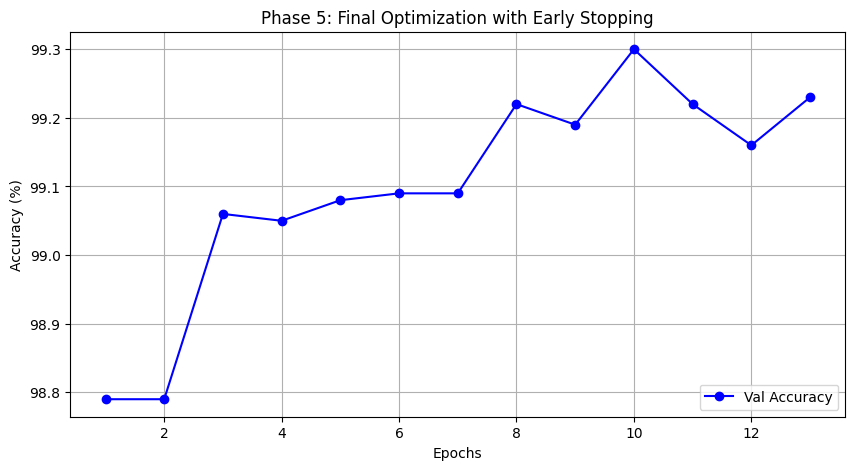

Final Experiment Complete. Best Validation Accuracy Achieved: 99.30%


In [8]:
import copy

final_model = CNN_Configurable(use_bn=True, dropout_rate=0.25).to(DEVICE)
optimizer = optim.SGD(final_model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

patience = 3
best_val_acc = 0.0
patience_counter = 0
max_epochs = 100

history = {'train_loss': [], 'val_acc': [], 'epochs': []}

print(f"--- Final Optimization with Early Stopping ---")

for epoch in range(max_epochs):
    final_model.train()
    running_loss = 0.0

    for data, target in train_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = final_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    final_model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = final_model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_acc = 100. * correct / len(test_loader.dataset)

    history['train_loss'].append(avg_train_loss)
    history['val_acc'].append(val_acc)
    history['epochs'].append(epoch + 1)

    print(f"Epoch {epoch+1}: Loss={avg_train_loss:.4f} | Val Acc={val_acc:.2f}%", end="")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        best_model_state = copy.deepcopy(final_model.state_dict())
        print(" (New Best)")
    else:
        patience_counter += 1
        print(f" (No Improv. {patience_counter}/{patience})")

        if patience_counter >= patience:
            print(f"\nEarly stopping triggered at Epoch {epoch+1}. Best Accuracy: {best_val_acc:.2f}%")
            break

final_model.load_state_dict(best_model_state)

plt.figure(figsize=(10, 5))

plt.plot(history['epochs'], history['val_acc'], 'b-', label='Val Accuracy', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title("Phase 5: Final Optimization with Early Stopping")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"Final Experiment Complete. Best Validation Accuracy Achieved: {best_val_acc:.2f}%")

###Optimal Model Configuration

Architecture: CNN-1

Activation Function: ReLU

Optimizer: SDG with Momentum

Batch Normalization

Dropout: 0.25

###Accuracy Achieved

We have managed to achieve an accuracy of 99.3%

##Comparison Table
The following is a table of every configuration tried throughout this assignment along with the best accuracy achieved.
| Configuration | Architecture | Activation | Optimizer | Batch Normalization | Dropout | Best Validation Accuracy |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| 1 | MLP-1 | ReLU | Adam | Yes | 0 | 98.41 |
| 2 | MLP-2 | ReLU | Adam | Yes | 0 | 98.47 |
| 3 | CNN | ReLU | SGD | No | 0.25 | 98.53 |
| 4 | CNN | Tanh | Adam | No | 0.25 | 98.55 |
| 5 | CNN | Sigmoid | Adam | No | 0.25 | 99.02 |
| 6 | CNN | ReLU | SGD w/ Momentum | No | 0 | 99.09 |
| 7 | CNN | ReLU | SGD w/ Momentum | No | 0.1 | 99.1 |
| 8 | CNN | ReLU | Adam | No | 0.25 | 99.11 |
| 9 | CNN | ReLU | SGD w/ Momentum | No | 0.25 | 99.18 |
| 10 | CNN | ReLU | SGD w/ Momentum | Yes | 0.25 | 99.3 |